In [1]:
import os, shutil, sys, random, cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.optimizers import SGD
from tensorflow.python.keras.utils import np_utils
from tensorflow.keras import backend as K
K.set_image_data_format('channels_last')
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import backend as K
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import History
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.callbacks import EarlyStopping
import seaborn as sns
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from random import choice

from google.colab import drive
drive.mount('/content/drive')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
dataset_dividido_folder = 'drive/My Drive/brain_tumor_dataset_dividido/'

treino_folder = 'treino/'
teste_folder = 'teste/'

dataset_dividido_folder_treino = dataset_dividido_folder + treino_folder
dataset_dividido_folder_teste = dataset_dividido_folder + teste_folder

#### Criar dois ImageDataGenerator, uma para treino, outro para teste. Apenas é executada data augmentation nos dados de treino. Nestes, são realizadas transformações verticais e horizontais nas imagens. Realizamos também um rescale para normalizar os dados entre 0 e 1. Por fim, nos dados de treino, definimos 25% para validação

In [3]:
datagen_treino = ImageDataGenerator(rescale = 1./255,
                                    brightness_range=(0.7, 1.3),
                                    vertical_flip=True,
                                    horizontal_flip=True,
                                    validation_split = 0.25)

datagen_teste = ImageDataGenerator(rescale = 1./255)

#### Após termos os ImageDataGenerators, utilizamos o método flow_from_directory para especificar o diretório onde os dados estão contidos. Definimos um target_size para as imagens (ficando assim, todas com as mesmas dimensões). Definimos o color_mode como grayscale de modo a ficarmos apenas com 1 canal de cor (o que não acontecia com o parâmetro default que retornava as imagens com 3 canais de cor. Definimos o batch_size, o tipo de classe que, neste problema, é binário, e por fim, definimos uma seed

In [4]:
seed = 123

dados_treino = datagen_treino.flow_from_directory(
    dataset_dividido_folder_treino,
    target_size = (150,150),
    color_mode = "grayscale",
    batch_size = 32,
    class_mode="binary",
    subset='training',
    seed = seed)



dados_validacao = datagen_treino.flow_from_directory(
    dataset_dividido_folder_treino,
    target_size = (150,150),
    color_mode = "grayscale",
    batch_size = 32,
    class_mode="binary",
    subset='validation',
    seed = seed)

'''dados_validacao = datagen_validacao.flow_from_directory(
    dataset_dividido_folder_validacao,
    target_size = (150,150),
    color_mode = "grayscale",
    batch_size = 30,
    class_mode="binary",
    seed = seed)'''

dados_teste = datagen_teste.flow_from_directory(
    dataset_dividido_folder_teste,
    target_size = (150,150),
    color_mode = "grayscale",
    batch_size = 32,
    class_mode = 'binary'
    )

print(dados_treino.class_indices)

Found 145 images belonging to 2 classes.
Found 47 images belonging to 2 classes.
Found 64 images belonging to 2 classes.
{'no': 0, 'yes': 1}


#### Foi acrescentado ReduceLROnPlateau callback ao modelo. Aplicando ReduceLROnPlateau reduz a taxa de aprendizagem por um fator de 2-10 quando o processo de aprendizagem estagna. O callback monitoriza o processo e se não houver melhorias em 'patience' epochs seguidas, a taxa de aprendizagem é reduzida. É guardado também os pesos do melhor modelo em relação à val_accuracy nas várias épocas. 

In [6]:
#Foi acrescentado ReduceLROnPlateau callback ao modelo.
#Aplicando ReduceLROnPlateau  reduz a taxa de aprendizagem por um fator de 2-10 quando o processo de aprendizagem estagna.
#O callback monitoriza o processo e se não houver melhorias em 'patience' epochs seguidas, a taxa de aprendizagem é reduzida.
Reduce_learning_rate = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.1, patiente = 2, cooldown = 2, min_lr = 0.00001, verbose = 1)
checkpointer = ModelCheckpoint(filepath="best_weights.hdf5", monitor = 'val_accuracy', verbose=1, save_best_only=True)
callbacks = [checkpointer,Reduce_learning_rate]

#### Criação do modelo dinâmico para se efetuar a otimização dos hiperparâmetros

In [7]:
def setup_model_dynamic(num_neurons, input_size, output_size, dropout_size, activation, activation_output, num_newLayers):
    model = Sequential()
    model.add(Conv2D(num_neurons,(3,3), input_shape = (150,150,1), activation = activation))
    model.add(MaxPooling2D(pool_size = (2,2)))
    for i in range(1, num_newLayers):
        model.add(Conv2D(num_neurons * 2,(3,3), activation = activation))
        model.add(MaxPooling2D(pool_size = (2,2)))
        if dropout_size > 0: model.add(Dropout(dropout_size))
    model.add(Flatten())
    model.add(Dropout(dropout_size))
    model.add(Dense(64, activation = activation))
    model.add(Dense(1, activation= activation_output))
    
    return model

#### Função para a otimização da função otimizer do modelo

In [8]:
def setup_compile_model(model, optimizer, dados_treino, dados_validacao, lr, loss, epochs, steps_per_epochs, metric):
    if optimizer == 'adam':
        opt = tf.keras.optimizers.Adam(learning_rate = lr)
    elif optimizer == 'RMSprop':
        opt = tf.keras.optimizers.Rmsprop(learning_rate = lr)
    else: opt = tf.keras.optimizers.Adam(learning_rate = lr)
    model.compile(loss = loss, optimizer = opt, metrics = ["accuracy"])
    history = model.fit(dados_treino, steps_per_epoch = steps_per_epochs, epochs = epochs, validation_data = dados_validacao, callbacks = callbacks, verbose = 1)
    return model,history

#### Função principal para correr o modelo, onde é definidos os possíveis valores para cada hiperparâmetro e em função do número de iterações são criados I modelos e é guardado o melhor conjunto de hiperparâmetros. A otimização dos hiperparâmetros é realizada com base numa pesquisa aleatória (random search).

In [9]:
def run_dnn(dados_treino, dados_validacao, dados_teste, num_iterations, verbose = True):
    best_accuracy = 0
    num_neuron = [64, 32]
    input_size = (150,150,1)
    output_size = 1
    dropouts = [0.2, 0.4, 0.5]
    metric = ['accuracy']
    activations = ['relu', 'tanh']
    activations_output = ['sigmoid']
    losses = ['binary_crossentropy']
    optimizers = [ 'adam', 'rmsprop', 'sgd_momentum']
    epoch = [30, 15, 20]
    steps_per_epochs = [5]
    learning_rates = [0.001, 0.0001]
    num_newLayers = [1,2,3,4]
    
    for i in range(num_iterations):
        num_neurons = choice(num_neuron)
        dropout = choice(dropouts)
        metrics = choice(metric)
        optimizer = choice(optimizers)
        activation = choice(activations)
        activation_output = choice(activations_output)
        loss = choice(losses)
        epochs = choice(epoch)
        steps_per_epoch = choice(steps_per_epochs)
        learning_rate = choice(learning_rates)
        num_newLayer = choice(num_newLayers)
        model = setup_model_dynamic(num_neurons, input_size, output_size, dropout, activation, activation_output, num_newLayer)
        model, history = setup_compile_model(model, optimizer,dados_treino, dados_validacao, learning_rate, loss, epochs, steps_per_epoch, metrics)
        val_loss, val_accuracy = model.evaluate(dados_teste, verbose = 0)
        
        if verbose:
            print("num_neurons\tDropout\tactivation\tactivation_output\tval_loss\tval_accuracy\n")
            print(num_neurons, "\t", dropout, "\t", "\t", activation, "\t", activation_output,"\t", val_loss, "\t", val_accuracy)
        
        if val_accuracy > best_accuracy:
            best_accuracy = val_accuracy
            best_configurations = (num_neurons, dropout, activation, activation_output, optimizer, loss, epochs, steps_per_epoch, learning_rate, metrics, num_newLayer)
    print("Best Accuracy: ", best_accuracy) 
    print("Configurations of model: Nª neurons: " + str(best_configurations[0]) + " dropout: "+ str(best_configurations[1]) + " activation: "+ str(best_configurations[2]) + " activation_output: "+ str(best_configurations[3]) + " activation_output: "+ str(best_configurations[4]) + " loss: "+ str(best_configurations[5]) + " epochs: " + str(best_configurations[6]) + " steps_per_epoch: " + str(best_configurations[7])+ " learning rate: " + str(best_configurations[8]) + " metric: " + str(best_configurations[9]) + " num_newLayers: " + str(best_configurations[10]) )
    return best_configurations

#### Chamar o método otimização

In [10]:
best_configurations = run_dnn(dados_treino, dados_validacao, dados_teste, 10)

Epoch 1/20
5/5 [==============================] - ETA: 0s - loss: 0.9120 - accuracy: 0.5724
Epoch 00001: val_accuracy improved from -inf to 0.63830, saving model to best_weights.hdf5
5/5 [==============================] - 63s 13s/step - loss: 0.9120 - accuracy: 0.5724 - val_loss: 0.6141 - val_accuracy: 0.6383 - lr: 0.0010
Epoch 2/20
5/5 [==============================] - ETA: 0s - loss: 0.6070 - accuracy: 0.6690
Epoch 00002: val_accuracy did not improve from 0.63830
5/5 [==============================] - 1s 213ms/step - loss: 0.6070 - accuracy: 0.6690 - val_loss: 0.5447 - val_accuracy: 0.6383 - lr: 0.0010
Epoch 3/20
5/5 [==============================] - ETA: 0s - loss: 0.5726 - accuracy: 0.6897
Epoch 00003: val_accuracy improved from 0.63830 to 0.76596, saving model to best_weights.hdf5
5/5 [==============================] - 1s 194ms/step - loss: 0.5726 - accuracy: 0.6897 - val_loss: 0.4681 - val_accuracy: 0.7660 - lr: 0.0010
Epoch 4/20
5/5 [==============================] - ETA: 0s -

# Modelo Final

In [11]:
best_model = setup_model_dynamic(best_configurations[0], 1, 1, best_configurations[1], best_configurations[2], best_configurations[3], best_configurations[10])
best_model, history = setup_compile_model(best_model, best_configurations[0], dados_treino, dados_validacao, best_configurations[8], best_configurations[5], best_configurations[6], best_configurations[7], best_configurations[9])
scores = best_model.evaluate(dados_teste, verbose = 0)
print("Accuracy: ", scores[1] * 100)

Epoch 1/20
5/5 [==============================] - ETA: 0s - loss: 0.7227 - accuracy: 0.6138
Epoch 00001: val_accuracy did not improve from 0.95745
5/5 [==============================] - 1s 213ms/step - loss: 0.7227 - accuracy: 0.6138 - val_loss: 0.6334 - val_accuracy: 0.6596 - lr: 0.0010
Epoch 2/20
5/5 [==============================] - ETA: 0s - loss: 0.8481 - accuracy: 0.5034
Epoch 00002: val_accuracy did not improve from 0.95745
5/5 [==============================] - 1s 199ms/step - loss: 0.8481 - accuracy: 0.5034 - val_loss: 0.6111 - val_accuracy: 0.6170 - lr: 0.0010
Epoch 3/20
5/5 [==============================] - ETA: 0s - loss: 0.6814 - accuracy: 0.5862
Epoch 00003: val_accuracy did not improve from 0.95745
5/5 [==============================] - 1s 193ms/step - loss: 0.6814 - accuracy: 0.5862 - val_loss: 0.5424 - val_accuracy: 0.8511 - lr: 0.0010
Epoch 4/20
5/5 [==============================] - ETA: 0s - loss: 0.5849 - accuracy: 0.6621
Epoch 00004: val_accuracy did not improve

In [12]:
print(best_model.summary())

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_25 (Conv2D)           (None, 148, 148, 32)      320       
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_26 (MaxPooling (None, 36, 36, 64)        0         
_________________________________________________________________
dropout_25 (Dropout)         (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 34, 34, 64)        36928     
_________________________________________________________________
max_pooling2d_27 (MaxPooling (None, 17, 17, 64)      

#### Gráficos de accuracy e loss do modelo final na etapa de treino e validação.

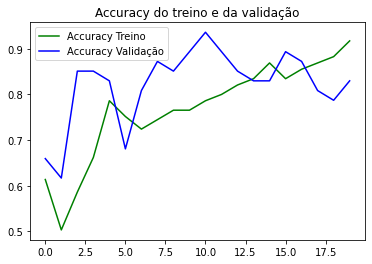

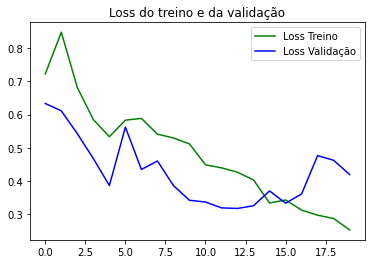

In [13]:
#Visualizar gráficos
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(accuracy))

#Gráfico Accuracy
plt.plot(epochs, accuracy, 'b', color = 'green', label = 'Accuracy Treino')
plt.plot(epochs, val_accuracy, 'b', label = 'Accuracy Validação')
plt.title('Accuracy do treino e da validação')
plt.legend()
plt.figure()

#Gráfico Loss
plt.plot(epochs, loss, 'b', color = 'green', label = 'Loss Treino')
plt.plot(epochs, val_loss, 'b', label = 'Loss Validação')
plt.title('Loss do treino e da validação')
plt.legend()
plt.show()

#### Teste de uma previsão e visualização da imagem a ser classificada.

X: (150, 150, 1)
y: ()


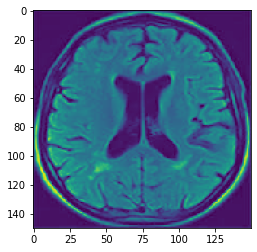

label: 0.0
antes do aumento de mais uma dimensão: (150, 150, 1)
depois do aumento de mais uma dimensão: (1, 150, 150, 1)
previsão: [[0.76215786]]
Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
Classe prevista: [[1]]


In [14]:
def visualize_previsao(img, img_class):
    print("X:",img.shape)
    print("y:",img_class.shape)
    plt.imshow(np.squeeze(img, axis=2))
    plt.show()
    print("label:",img_class)
    print("antes do aumento de mais uma dimensão:",img.shape)
    imagem_tensor = np.expand_dims(img, axis=0)
    print("depois do aumento de mais uma dimensão:",imagem_tensor.shape)
    print("previsão:",best_model.predict(imagem_tensor))
    classes = best_model.predict_classes(imagem_tensor)
    print('Classe prevista:',classes)
    return imagem_tensor
#dados_teste.__getitem__(0)[0], o primeiro 0 é a bacth dos dados, neste caso como dados_teste tem 52 imagens, uma bacth size de 10 vamos ter 6 batchs, podendo este número ir até 5
# O segundo 0 é se queremos os atributos ou as labels (1)
#dados_teste.__getitem__(0)[0][1] vamos buscar na bacth 0 os atributos da imagem 1 

imagem_tensor = visualize_previsao(dados_teste.__getitem__(0)[0][1], dados_teste.__getitem__(0)[1][1])

# Feature Maps

(None, 148, 148, 32)
(None, 74, 74, 32)
(None, 72, 72, 64)
(None, 36, 36, 64)
(None, 36, 36, 64)
(None, 34, 34, 64)
(None, 17, 17, 64)
(None, 17, 17, 64)
(None, 15, 15, 64)
(None, 7, 7, 64)
(None, 7, 7, 64)
(1, 148, 148, 32)


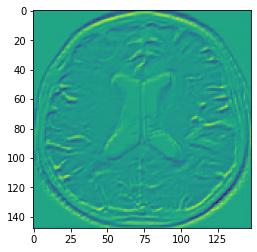

In [15]:
camadas_outputs = []
for layer in best_model.layers[:len(best_model.layers) - 4]:
    print(layer.output.shape)
    camadas_outputs.append(layer.output)

# e depois criamos um modelo que retorna estes outputs dado os inputs do modelo
activation_model = Model(inputs=best_model.input, outputs=camadas_outputs) 
activations = activation_model.predict(imagem_tensor)
first_layer_activation = activations[0]
print(first_layer_activation.shape)
plt.imshow(first_layer_activation[0, :, :, 9], cmap='viridis')
plt.show()

Nome da camada:  conv2d_25
Nome da camada:  max_pooling2d_25
Nome da camada:  conv2d_26
Nome da camada:  max_pooling2d_26
Nome da camada:  dropout_25
Nome da camada:  conv2d_27
Nome da camada:  max_pooling2d_27
Nome da camada:  dropout_26
Nome da camada:  conv2d_28
Nome da camada:  max_pooling2d_28
Nome da camada:  dropout_27
nome_camada: conv2d_25
n_features: 32
size: 148
n_linhas: 2
nome_camada: max_pooling2d_25
n_features: 32
size: 74
n_linhas: 2
nome_camada: conv2d_26
n_features: 64
size: 72
n_linhas: 2
nome_camada: max_pooling2d_26
n_features: 64
size: 36
n_linhas: 2
nome_camada: dropout_25
n_features: 64
size: 36
n_linhas: 2
nome_camada: conv2d_27
n_features: 64
size: 34
n_linhas: 2
nome_camada: max_pooling2d_27
n_features: 64
size: 17
n_linhas: 2
nome_camada: dropout_26
n_features: 64
size: 17
n_linhas: 2
nome_camada: conv2d_28
n_features: 64
size: 15
n_linhas: 2
nome_camada: max_pooling2d_28
n_features: 64
size: 7
n_linhas: 2
nome_camada: dropout_27
n_features: 64
size: 7
n_lin

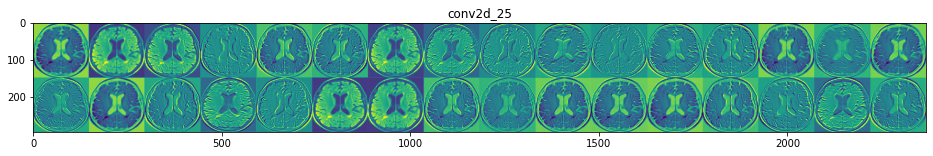

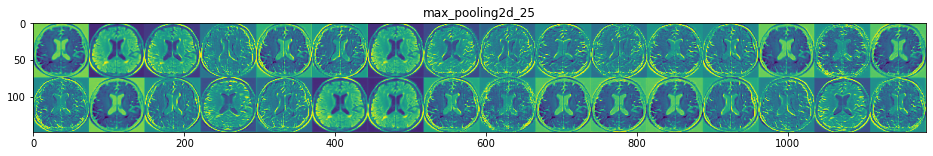

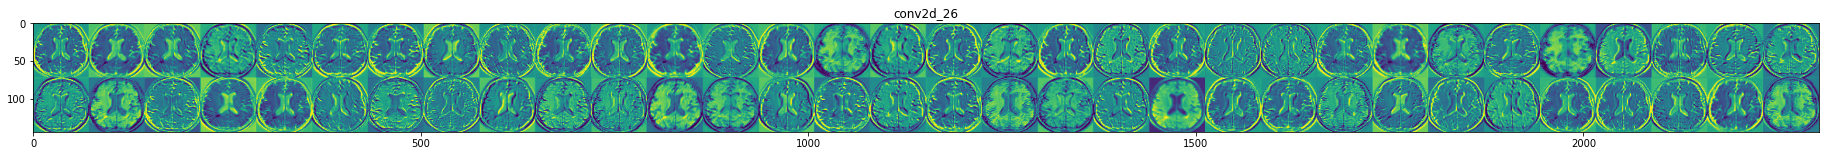

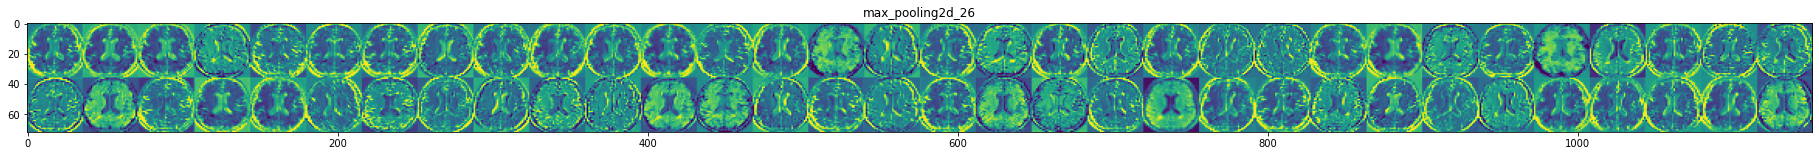

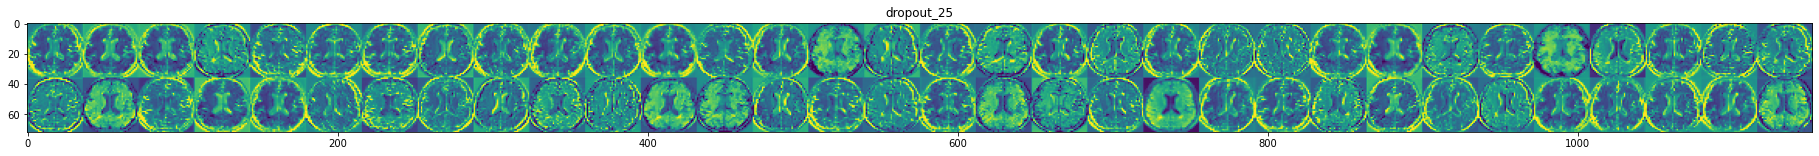

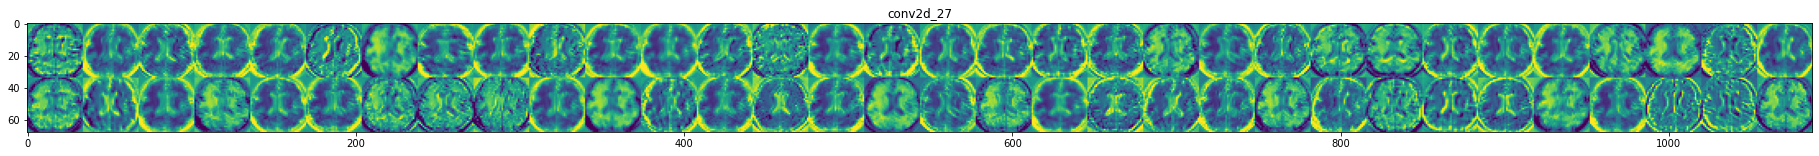

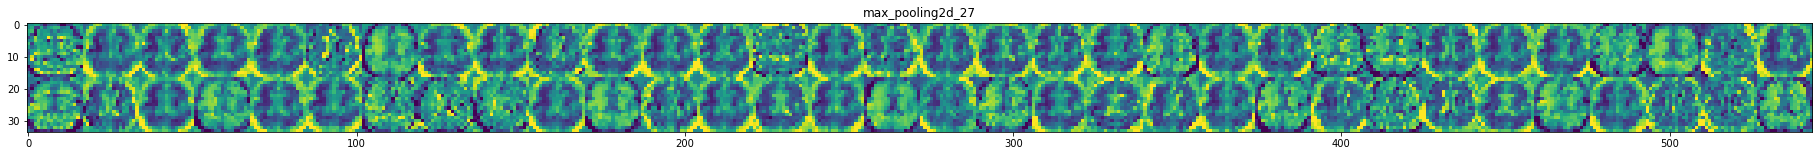

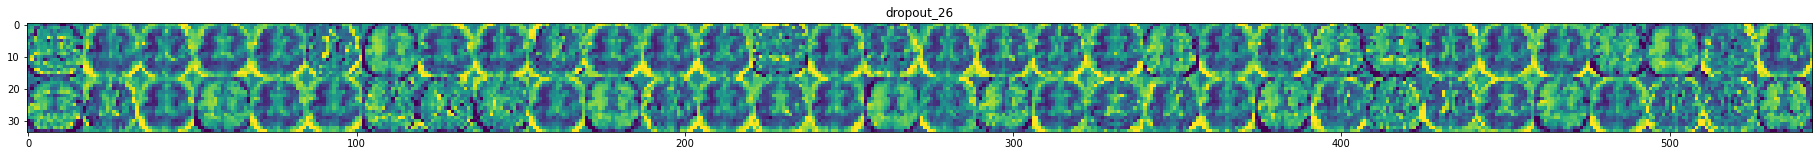

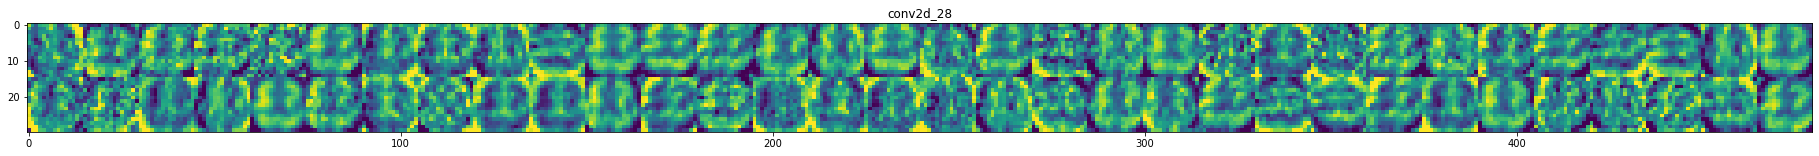

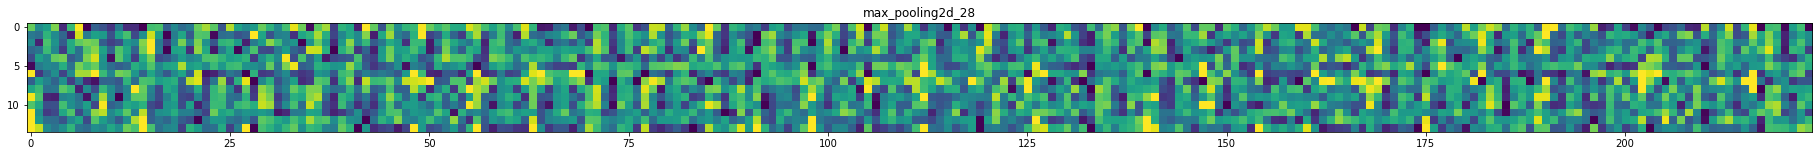

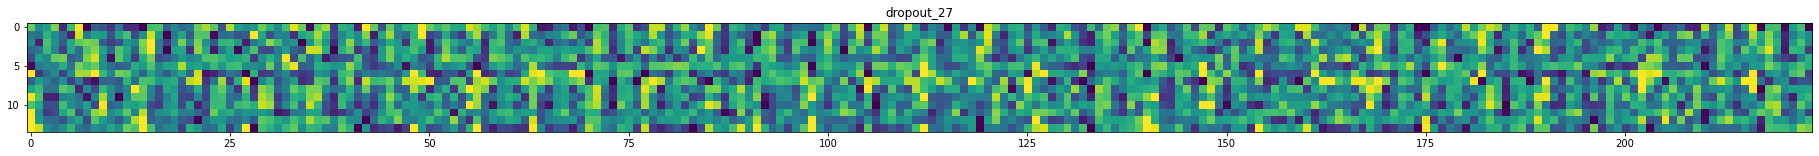

In [16]:
nome_camadas = []
for camada in best_model.layers[:len(best_model.layers) - 4]:
    print("Nome da camada: ", camada.name)
    nome_camadas.append(camada.name)

for nome_camada, ativacao_camada in zip(nome_camadas, activations): # o zip permite iterar simultaneamente em 2 listas
    n_features = ativacao_camada.shape[-1] # Numero de features no feature map, pois é o que está na ultima dimensão
    imagens_por_linha = int(n_features / 2)
    size = ativacao_camada.shape[1] #O feature map tem shape (1, tamanho, tamanho, numero_features).
    n_linhas = -(-n_features // imagens_por_linha) # Empilha os canais de ativação nesta matriz
    print("nome_camada:",nome_camada)
    print("n_features:",n_features)
    print("size:",size)
    print("n_linhas:",n_linhas)
    display_grid = np.zeros((size * n_linhas, imagens_por_linha * size))
    for col in range(n_linhas): 
        for lin in range(imagens_por_linha):
            #verificar aqui se a imagem existe
            imagem = ativacao_camada[0,:,:,col * imagens_por_linha + lin] #isto pode dar erro de out-of-range
            imagem -= imagem.mean() # pos-processamento para melhor visualização
            imagem /= imagem.std()
            imagem *= 64
            imagem += 128
            imagem = np.clip(imagem, 0, 255).astype('uint8') #valores <0 ficam 0 e >255 ficam = 255
            display_grid[col * size : (col + 1) * size,lin * size : (lin + 1) * size] = imagem
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(nome_camada)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')        

